In [1]:
import numpy as np
import pylab

import lal
import lalsimulation as lalsim
import lalframe

import gwpy
import pycbc
from pycbc import waveform

In [2]:
from pycbc import catalog #list of GW detections in O1/O2

for merger_name in catalog.Catalog():
    print(merger_name)

GW150914
GW151012
GW151226
GW170104
GW170608
GW170729
GW170809
GW170814
GW170817
GW170818
GW170823


In [3]:
# Let's focus on the following event for example

event = catalog.Merger("GW150914")

In [4]:
# Print the information that is stored about the event parameters

for key, value in event.data.items():
    if key != 'files':
        print(key, value)

E_rad {'best': 3.1, 'err': [-0.4, 0.4]}
L_peak {'best': 3.6, 'err': [-0.4, 0.4]}
a_final {'best': 0.69, 'err': [-0.04, 0.05]}
chi_eff {'best': -0.01, 'err': [-0.13, 0.12]}
distance {'best': 430.0, 'err': [-170.0, 150.0]}
far_cwb {'best': 0.000163, 'err': 'upperbound'}
far_gstlal {'best': 1e-07, 'err': 'upperbound'}
far_pycbc {'best': 1.5300000000000003e-05, 'err': 'upperbound'}
mass1 {'best': 35.6, 'err': [-3.0, 4.8]}
mass2 {'best': 30.6, 'err': [-4.4, 3.0]}
mchirp {'best': 28.6, 'err': [-1.5, 1.6]}
mfinal {'best': 63.1, 'err': [-3.0, 3.3]}
redshift {'best': 0.09, 'err': [-0.03, 0.03]}
sky_size {'best': 179.0}
snr_cwb {'best': 25.2}
snr_gstlal {'best': 24.4}
snr_pycbc {'best': 23.6}
tc {'best': 1126259462.4}
utctime {'best': '09:50:45.4'}


In [5]:
# Let's access the detector strain for this event

data = {}
for ifo in ['H1', 'L1']:
    data[ifo] = event.strain(ifo)

print("Duration: {}s Start: {} End: {} Merger Time: {} ".format(data['H1'].duration, 
                                              int(data['H1'].start_time),
                                              int(data['H1'].end_time),
                                              event.data['tc']['best']))

Duration: 32.0s Start: 1126259447 End: 1126259479 Merger Time: 1126259462.4 


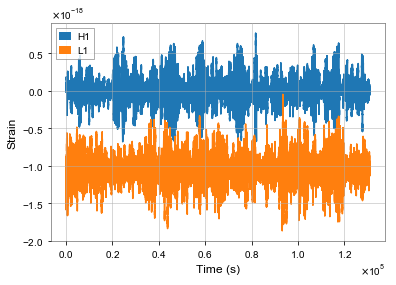

In [6]:
pylab.plot(data['H1'], label='H1')
pylab.plot(data['L1'], label='L1')
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

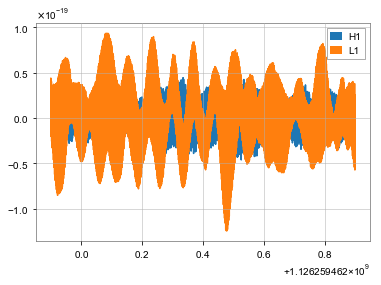

In [6]:
#----------------
# PROCESS DATA
#----------------

high_data = {}
conditioned = {}

for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data[ifo] = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # Let's also crop the data to delete artifacts from the filter
    
    conditioned[ifo] = high_data[ifo].crop(8, 8)
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data[ifo].time_slice(event.time - 0.5, event.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

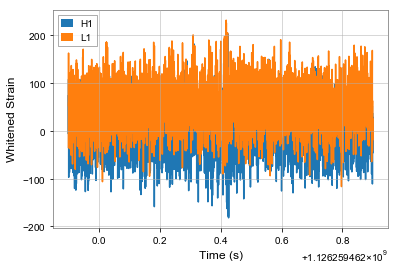

In [8]:
#-------------------------
# WHITEN THE DATA
#-------------------------

whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = high_data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(event.time - 0.5, event.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

In [7]:
#Now we zoom in the data

pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    #if ifo == 'L1':
    #    bpsd.roll(int(bpsd.sample_rate * .007))
    #    bpsd *= -1
        
    # We'll choose a tighter zoom here.    
    zoom = bpsd.time_slice(event.time - 0.1, event.time + 0.1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

NameError: name 'whitened' is not defined

<Figure size 1080x216 with 0 Axes>

Frequency vs time nice plot
----

In [ ]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(event.time - 5, event.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(event.time - 0.5, event.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

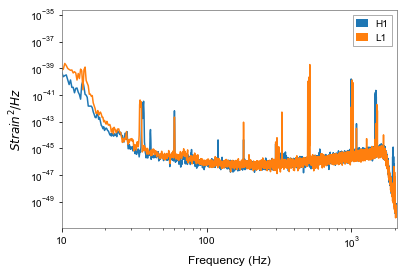

In [12]:
#--------------------------------
# COMPUTE THE PSD OF THE DATA 
#--------------------------------

for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd, label=ifo)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.legend()
pylab.show()

-----
Waveform template using SEOBNRv4
-----

In [ ]:
# Let's produce a template with the signal estimated parameters

from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=event.data['mass1']['best'],
                         mass2=event.data['mass2']['best'],
                         distance=event.data['distance']['best'],
                         delta_t=1.0/4096,
                         f_lower=10)

pylab.plot(hp.sample_times,hp)

Comparison of the PSD of the data and template

In [ ]:
# Compare template amplitude with detector strain

# First we Fourier transform the template to frequency domain using a wrapper of pycbc
hp_FD = hp.to_frequencyseries()
hc_FD = hc.to_frequencyseries()

# We then compute the amplitude (absolute value) of the complex strain
amp_fd = np.abs(hp_FD.data + 1j*hc_FD.data)

# We plot it with the detector's PSD to compare the strength of the signal with the noise

for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd, label=ifo)

pylab.loglog(hp_FD.sample_frequencies,amp_fd**2, label='template')
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
#pylab.ylim(1e-59,1e-35)
pylab.legend()
pylab.show()

SNR of the template with detector data
-------

In [ ]:
# Now we can compute the SNR (Signal-to-Noise ratio) timeseries of the template with
# detector data
from pycbc.psd import interpolate, inverse_spectrum_truncation

from pycbc.filter import matched_filter

# First we resize the template to the data length and sampling, using a pycbc wrapper

hp.resize(len(conditioned['L1']))

# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)

# Choose the PSD for computing the noise-weighted inner product

psd = data['H1'].psd(4)

# Interpolate PSD to data resolution and filter off the low frequencies

psd = interpolate(psd, conditioned["H1"].delta_f)

psd = inverse_spectrum_truncation(psd, 4 * conditioned['H1'].sample_rate,
                                  low_frequency_cutoff=15)

snr_H1 = matched_filter(template, conditioned['H1'],
                     psd=psd, low_frequency_cutoff=20)

# Now the same for L1

psd = data['L1'].psd(4)

# Interpolate PSD to data resolution and filter off the low frequencies

psd = interpolate(psd, conditioned["L1"].delta_f)

psd = inverse_spectrum_truncation(psd, 4 * conditioned['L1'].sample_rate,
                                  low_frequency_cutoff=15)

snr_L1 = matched_filter(template, conditioned['L1'],
                     psd=psd, low_frequency_cutoff=20)

tc = event.data['tc']['best']

pylab.plot(snr_H1.sample_times,np.abs(snr_H1),label='SNR timeseries H1')
pylab.plot(snr_L1.sample_times,np.abs(snr_L1),label='SNR timeseries L1')
pylab.axvline(tc,color='red',label='merger time')
pylab.xlim(tc -1, tc+1)
pylab.ylim(0,20)
pylab.legend()
pylab.show()

# Seems that we can recover the snr peak but not very clear

Network SNR
--------

In [16]:
# Let's compute the network SNR

max_snr_H1 = max(np.abs(snr_H1.data[21000:-4000]))
max_snr_L1 = max(np.abs(snr_L1.data[21000:-4000]))

print("Max SNR H1: ", max_snr_H1)
print("Max SNR L1: ", max_snr_L1)

network_SNR = np.sqrt( max_snr_H1**2 + max_snr_L1**2 )

print("Network SNR: ", network_SNR)

# Let's compare with reported network SNR of the event

print("Event network SNR according to metadata: ", event.data["snr_pycbc"]["best"])

print("We don't recover the full reported SNR, but we are close. Maybe data has to be processed more carefully!")

('Max SNR H1: ', 17.542776116854686)
('Max SNR L1: ', 13.310874949884912)
('Network SNR: ', 22.021089569264298)
('Event network SNR according to metadata: ', 23.6)
We don't recover the full reported SNR, but we are close. Maybe data has to be processed more carefully!


-----------------
Aligning and Subtracting the Proposed Signal
-----------------

In [257]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = event.data['tc']['best'] - conditioned['H1'].start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

peak = abs(snr_L1).numpy().argmax()
snrp = snr_L1[peak]
# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned['H1'].start_time

Visualizing the overlap between the template-waveform and data
---------------------------

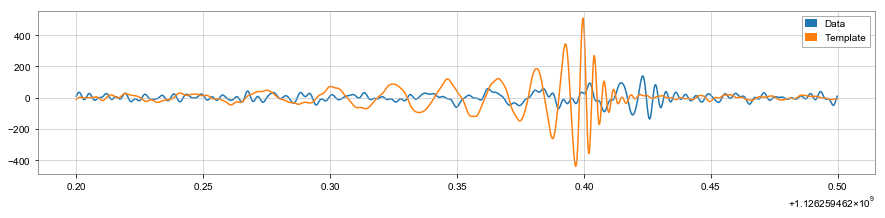

In [260]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned['H1'].to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = whitened['H1'].highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(event.time-.2, event.time+.1)
white_template = white_template.time_slice(event.time-.2, event.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

Computing the match
-----------

In [261]:
match = white_data.match(white_template)

print(match[0])

0.815886537059017


Explore parameter space behaviour with match surfaces
-------

In [273]:
# Here we are going to plot the match contour surface around a point of the parameter
# space as we vary mass1 and mass2 with respect a fixed waveform.



# Create an array of values of mass1 and mass2 to compute the match at each point

m1_array = np.arange(20, 45, 0.5)
m2_array = np.arange(20,41,0.5)

matches = np.zeros((len(m1_array),len(m2_array)),dtype=np.float)

for i, m1 in enumerate(m1_array):
    for j, m2 in enumerate(m2_array):
        
        temp_p, temp_c =  waveform.get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=m1, mass2=m2,
                                  spin1z=0., spin2z=0.,
                                  delta_t=1.0/4096,
                                  f_lower=20)

        matches[i,j] = conditioned['L1'].match(temp_p)[0]

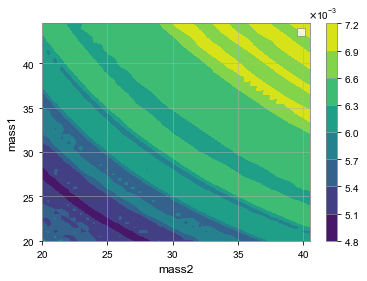

In [275]:
pylab.contourf(m2_array, m1_array, matches)
pylab.colorbar()
pylab.xlabel('mass2')
pylab.ylabel('mass1')
pylab.legend()
pylab.show()